In [1]:
################################################################################
# R CODE INCLUDED AS SUPPLEMENTARY ONLINE MATERIAL FOR:
#   "Time series regression studies in environmental epidemiology"
#   Bhaskaran K, ....
################################################################################

# LOAD THE DATA INTO THE SESSION
# (THE DATA ARE STORED IN A STATA'S .dta FILE)
# (THE FUNCTION read.dta IN THE PACKAGE foreign CAN DO THE JOB)
# (THE PACKAGE IS NOT PRE-LOADED INTO THE SESSION AND NEEDS TO BE LOADED)
library(foreign)
#data <- read.dta("ije-2012-10-0989-File003.dta")
data <- read.csv(file="./soton_aquality.csv", header=TRUE, sep=",")

# SET THE DEFAULT ACTION FOR MISSING DATA TO na.exclude
# (MISSING EXCLUDED IN ESTIMATION BUT RE-INSERTED IN PREDICTION/RESIDUALS)
options(na.action="na.exclude")

# CONVERT DATE COLUMN TO DATE FORMAT
data$date <- as.Date(data$date, format = "%Y-%m-%d")

# CHOOSE VARIABLES
data$target <- data$total_ed_attendance
data$pollutant <- data$pm10_ugm3
data$temperature <- data$air_temp_min

data

      date                   date.1    total_ed_attendance
 Min.   :2014-06-04   2014-06-04:  1   Min.   : 0.00      
 1st Qu.:2014-11-17   2014-06-05:  1   1st Qu.:10.00      
 Median :2015-05-03   2014-06-06:  1   Median :13.00      
 Mean   :2015-05-03   2014-06-07:  1   Mean   :13.48      
 3rd Qu.:2015-10-16   2014-06-08:  1   3rd Qu.:16.00      
 Max.   :2016-03-31   2014-06-09:  1   Max.   :35.00      
                      (Other)   :661                      
 total_admissions_from_ed  air_temp_ave    air_temp_min    air_temp_max  
 Min.   : 0.000           Min.   : 0.50   Min.   :-2.40   Min.   : 3.00  
 1st Qu.: 6.000           1st Qu.: 8.10   1st Qu.: 5.40   1st Qu.:10.90  
 Median : 8.000           Median :12.00   Median : 9.30   Median :14.30  
 Mean   : 8.438           Mean   :11.75   Mean   : 8.97   Mean   :14.55  
 3rd Qu.:11.000           3rd Qu.:15.60   3rd Qu.:12.75   3rd Qu.:18.55  
 Max.   :24.000           Max.   :22.90   Max.   :19.80   Max.   :29.80  
          

,total_admissions_from_ed,air_temp_ave,air_temp_min,air_temp_max,relative_humidity_percrh
total_admissions_from_ed,1.00000000,-0.29461913,-0.2674553,-0.30046508,0.04154038
air_temp_ave,-0.29461913,1.00000000,0.9611686,0.96393926,0.09881439
air_temp_min,-0.26745525,0.96116860,1.0000000,0.87477388,0.10763095
air_temp_max,-0.30046508,0.96393926,0.8747739,1.00000000,0.06158603
relative_humidity_percrh,0.04154038,0.09881439,0.1076310,0.06158603,1.00000000


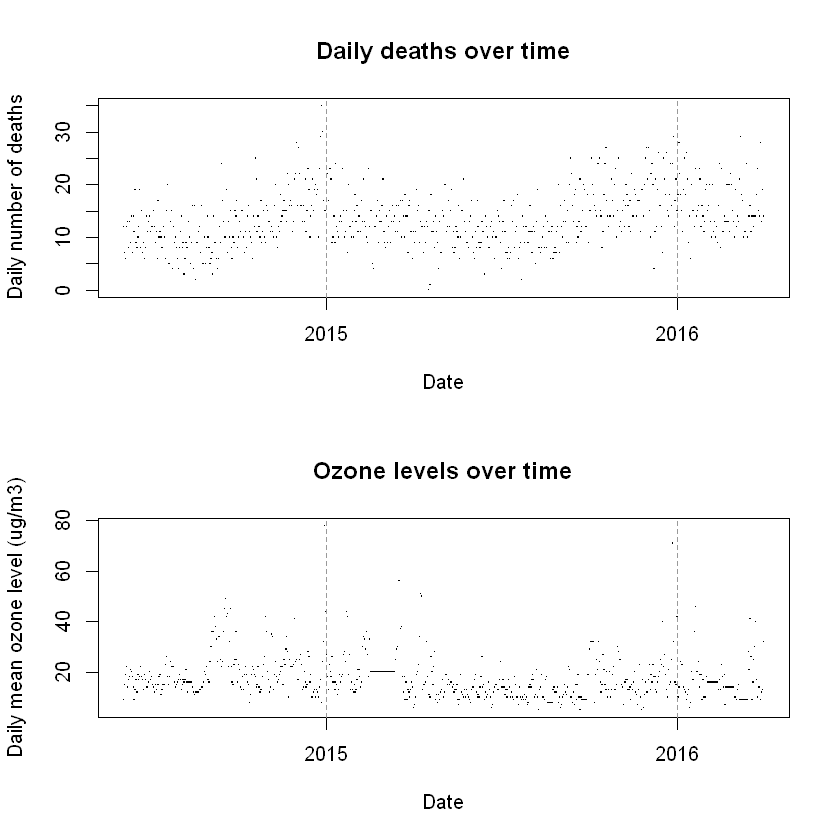

In [2]:
################################################################################
# PRELIMINARY ANALYSIS
#######################

#############
# FIGURE 1
#############

# SET THE PLOTTING PARAMETERS FOR THE PLOT (SEE ?par)
oldpar <- par(no.readonly=TRUE)
par(mex=0.8,mfrow=c(2,1))

# SUB-PLOT FOR DAILY DEATHS, WITH VERTICAL LINES DEFINING YEARS
plot(data$date,data$target,pch=".",main="Daily deaths over time",
  ylab="Daily number of deaths",xlab="Date")
abline(v=data$date[grep("-01-01",data$date)],col=grey(0.6),lty=2)

# THE SAME FOR OZONE LEVELS
plot(data$date,data$pollutant,pch=".",main="Ozone levels over time",
     ylab="Daily mean ozone level (ug/m3)",xlab="Date")
abline(v=data$date[grep("-01-01",data$date)],col=grey(0.6),lty=2)
par(oldpar)
layout(1)

########################
# DESCRIPTIVE STATISTICS
########################

# SUMMARY
summary(data)

# OTHER USEFUL FUNCTIONS IN THE PACKAGE epicals
# (THE PACKAGE IS NOT PRESENT IN THE DEFAULT R INSTALLATION)
# (IT NEED TO BE INSTALLED AND THEN LOADED INTO THE SESSION)
#install.packages("epicalc") # is this only required for 2 commands below
#library(epicalc)
#des(data)
#summ(data)

# CORRELATIONS
#cor(data[,2:4])
cor(data[,4:8])
#################
# SCALE EXPOSURE
#################

#data$ozone10 <- data$ozone/10


Call:
glm(formula = target ~ month/year, family = quasipoisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.6260  -0.8233  -0.1556   0.6996   3.5610  

Coefficients: (14 not defined because of singularities)
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        2.37024    0.06731  35.213  < 2e-16 ***
monthAug          -0.16944    0.09862  -1.718 0.086243 .  
monthDec           0.56224    0.08384   6.706 4.38e-11 ***
monthFeb           0.34010    0.08869   3.835 0.000138 ***
monthJan           0.45726    0.08548   5.349 1.23e-07 ***
monthJul          -0.03591    0.09527  -0.377 0.706344    
monthJun           0.01750    0.09735   0.180 0.857408    
monthMar           0.38198    0.08674   4.404 1.25e-05 ***
monthMay           0.15935    0.09094   1.752 0.080202 .  
monthNov           0.31533    0.08852   3.562 0.000395 ***
monthOct           0.13594    0.09142   1.487 0.137523    
monthSep          -0.01887    0.09565  -0.1

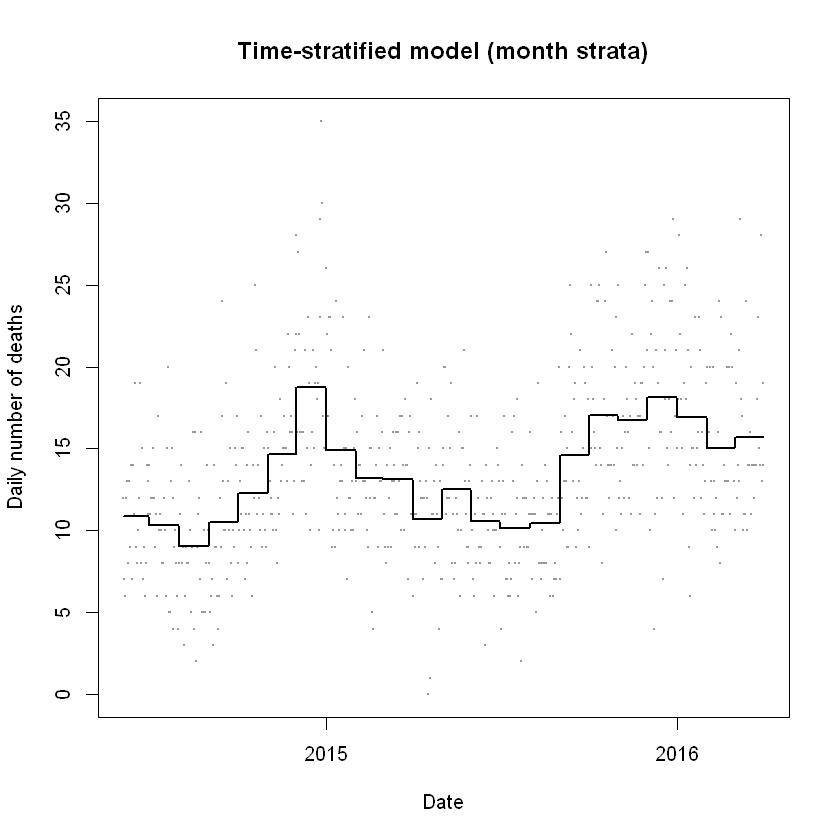

In [3]:
################################################################################
# MODELLING SEASONALITY AND LONG-TERM TREND
# (LEAVING OUT MAIN EXPOSURE FOR NOW)
############################################

##################################
# OPTION 1: TIME-STRATIFIED MODEL
# (SIMPLE INDICATOR VARIABLES)
##################################

# GENERATE MONTH AND YEAR
data$month <- as.factor(months(data$date,abbr=TRUE))
data$year <- as.factor(substr(data$date,1,4))

# FIT A POISSON MODEL WITH A STRATUM FOR EACH MONTH NESTED IN YEAR
# (USE OF quasipoisson FAMILY FOR SCALING THE STANDARD ERRORS)
model1 <- glm(target ~ month/year,data,family=quasipoisson)
summary(model1)

# COMPUTE PREDICTED NUMBER OF DEATHS FROM THIS MODEL
pred1 <- predict(model1,type="response")

#############
# FIGURE 2A
#############

#plot(data$date,data$num_deaths,ylim=c(100,300),pch=19,cex=0.2,col=grey(0.6),
#  main="Time-stratified model (month strata)",ylab="Daily number of deaths",
#  xlab="Date")

plot(data$date,data$target,pch=19,cex=0.2,col=grey(0.6),
     main="Time-stratified model (month strata)",ylab="Daily number of deaths",
     xlab="Date")
lines(data$date,pred1,lwd=2)

In [4]:
#####################################
# OPTION 2: PERIODIC FUNCTIONS MODEL
# (FOURIER TERMS)
#####################################

# GENERATE FOURIER TERMS
# (USE FUNCTION harmonic, IN PACKAGE tsModel TO BE INSTALLED AND THEN LOADED)
install.packages("tsModel", repos='http://cran.us.r-project.org')
library(tsModel)

package 'tsModel' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\bjk1y13\AppData\Local\Temp\RtmpCk5xk9\downloaded_packages


Warning message:
"package 'tsModel' was built under R version 3.5.3"Time Series Modeling for Air Pollution and Health (0.6)



Call:
glm(formula = target ~ fourier + time, family = quasipoisson, 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.9289  -0.9104  -0.1124   0.6878   3.7224  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.442e+00  2.817e-02  86.688  < 2e-16 ***
fourier1    -8.036e-02  1.955e-02  -4.111 4.44e-05 ***
fourier2    -2.364e-02  1.877e-02  -1.259 0.208301    
fourier3     7.906e-02  1.800e-02   4.393 1.30e-05 ***
fourier4    -2.105e-01  1.950e-02 -10.792  < 2e-16 ***
fourier5     7.072e-02  1.835e-02   3.855 0.000127 ***
fourier6     7.170e-03  1.813e-02   0.395 0.692634    
time         3.779e-04  7.192e-05   5.255 2.00e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for quasipoisson family taken to be 1.446011)

    Null deviance: 1362.46  on 666  degrees of freedom
Residual deviance:  967.95  on 659  degrees of freedom
AIC: NA

Number of Fisher Scoring iteratio

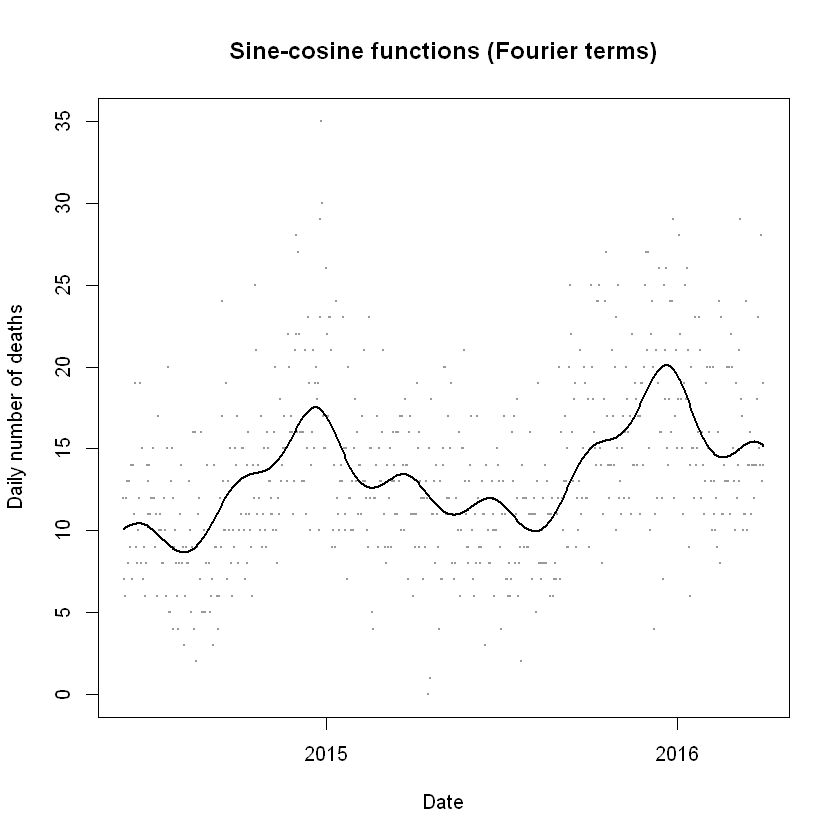

In [5]:
# 4 SINE-COSINE PAIRS REPRESENTING DIFFERENT HARMONICS WITH PERIOD 1 YEAR
data$time <- seq(nrow(data))
fourier <- harmonic(data$time,nfreq=3,period=365.25)

# FIT A POISSON MODEL FOURIER TERMS + LINEAR TERM FOR TREND
# (USE OF quasipoisson FAMILY FOR SCALING THE STANDARD ERRORS)
model2 <- glm(target ~ fourier + time,data,family=quasipoisson)
summary(model2)

# COMPUTE PREDICTED NUMBER OF DEATHS FROM THIS MODEL
pred2 <- predict(model2,type="response")

#############
# FIGURE 2B
#############
#plot(data$date,data$target,ylim=c(100,300),pch=19,cex=0.2,col=grey(0.6),
#     main="Sine-cosine functions (Fourier terms)",ylab="Daily number of deaths",
#     xlab="Date")

plot(data$date,data$target,pch=19,cex=0.2,col=grey(0.6),
  main="Sine-cosine functions (Fourier terms)",ylab="Daily number of deaths",
  xlab="Date")
lines(data$date,pred2,lwd=2)

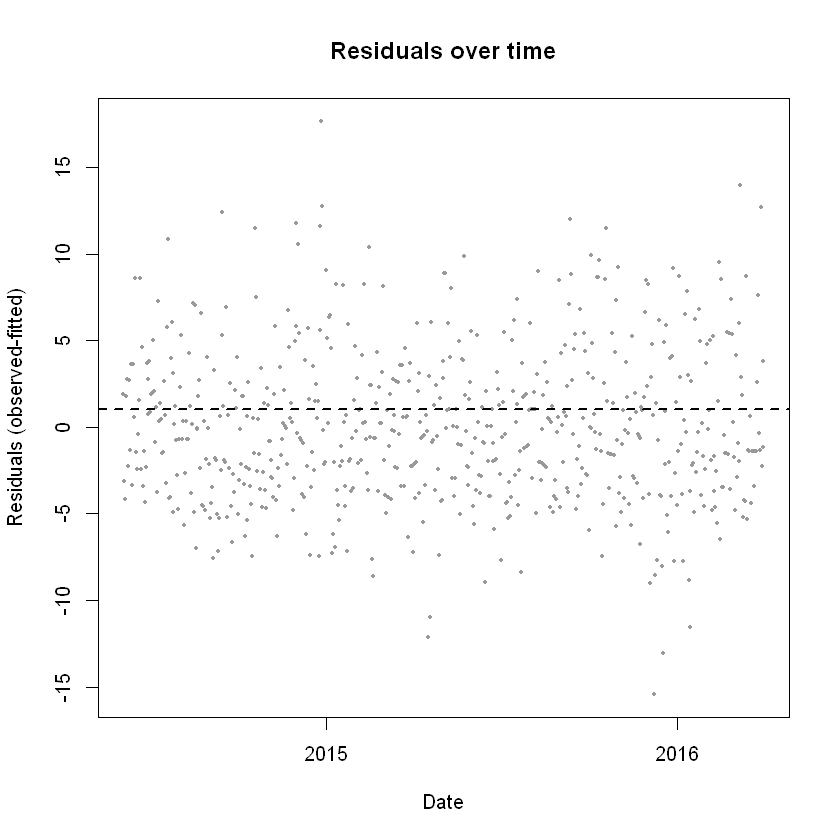

In [6]:
#####################################
# PLOT RESPONSE RESIDUALS OVER TIME
# FROM MODEL 3
#####################################

# GENERATE RESIDUALS
res3 <- residuals(model2,type="response")

############
# FIGURE 3
############

plot(data$date,res3,pch=19,cex=0.4,col=grey(0.6),
  main="Residuals over time",ylab="Residuals (observed-fitted)",xlab="Date")
abline(h=1,lty=2,lwd=2)

#,ylim=c(-50,150)


Call:
glm(formula = target ~ spl, family = quasipoisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.9184  -0.9162  -0.1571   0.7554   3.8027  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.25819    0.15614  14.462  < 2e-16 ***
spl1         0.40758    0.28646   1.423 0.155273    
spl2        -0.26323    0.18540  -1.420 0.156146    
spl3         0.06125    0.21289   0.288 0.773672    
spl4         0.58231    0.17574   3.314 0.000972 ***
spl5         0.63806    0.18698   3.412 0.000684 ***
spl6         0.10772    0.18364   0.587 0.557696    
spl7         0.33036    0.18915   1.747 0.081182 .  
spl8        -0.02238    0.18943  -0.118 0.905981    
spl9         0.13379    0.18779   0.712 0.476427    
spl10        0.64303    0.18242   3.525 0.000453 ***
spl11        0.62477    0.18481   3.381 0.000766 ***
spl12        0.55626    0.20143   2.762 0.005915 ** 
spl13        0.33129    0.20916   1.584 0.113692    
spl14

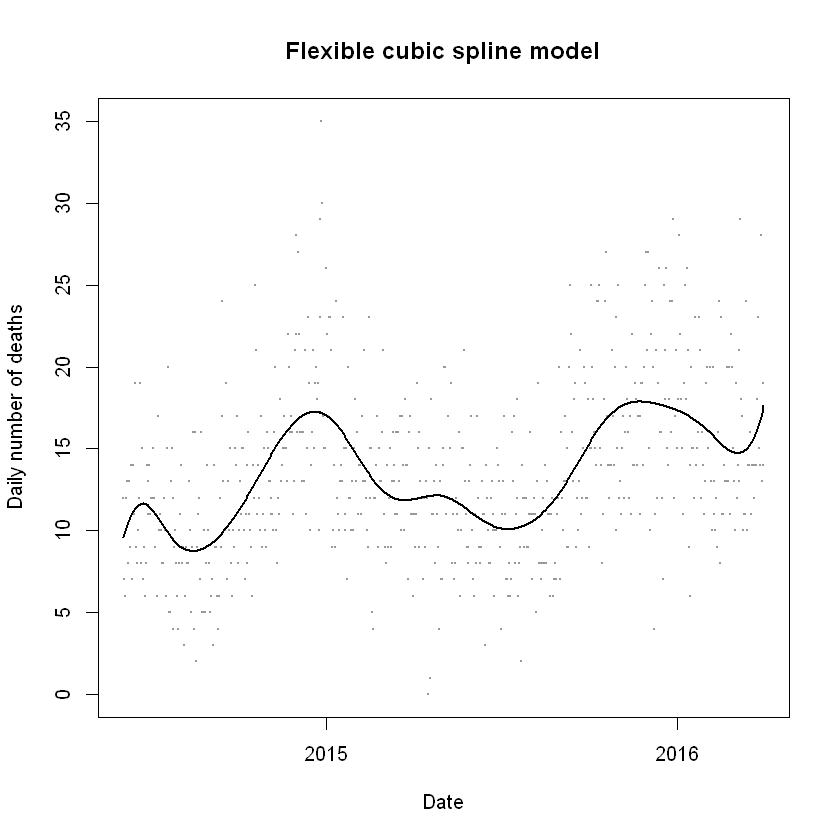

In [7]:
#####################################
# OPTION 3: SPLINE MODEL
# (FLEXIBLE SPLINE FUNCTIONS)
#####################################

# GENERATE SPLINE TERMS
# (USE FUNCTION bs IN PACKAGE splines, TO BE LOADED)
library(splines)

# A CUBIC B-SPLINE WITH 32 EQUALLY-SPACED KNOTS + 2 BOUNDARY KNOTS
# (NOTE: THIS PARAMETERIZATION IS SLIGHTLY DIFFERENT THAN STATA'S)
# (THE 35 BASIS VARIABLES ARE SET AS df, WITH DEFAULT KNOTS PLACEMENT. SEE ?bs)
# (OTHER TYPES OF SPLINES CAN BE PRODUCED WITH THE FUNCTION ns. SEE ?ns)
# spl <- bs(data$time,degree=3,df=12)
spl <- bs(data$time,degree=3,df=14)

# FIT A POISSON MODEL FOURIER TERMS + LINEAR TERM FOR TREND
# (USE OF quasipoisson FAMILY FOR SCALING THE STANDARD ERRORS)
model3 <- glm(target ~ spl,data,family=quasipoisson)
summary(model3)

# COMPUTE PREDICTED NUMBER OF DEATHS FROM THIS MODEL
pred3 <- predict(model3,type="response")

#############
# FIGURE 2C
#############

plot(data$date,data$target,pch=19,cex=0.2,col=grey(0.6),
     main="Flexible cubic spline model",ylab="Daily number of deaths",
     xlab="Date")
lines(data$date,pred3,lwd=2)
# this looks a bit overfit, fourier looks better.

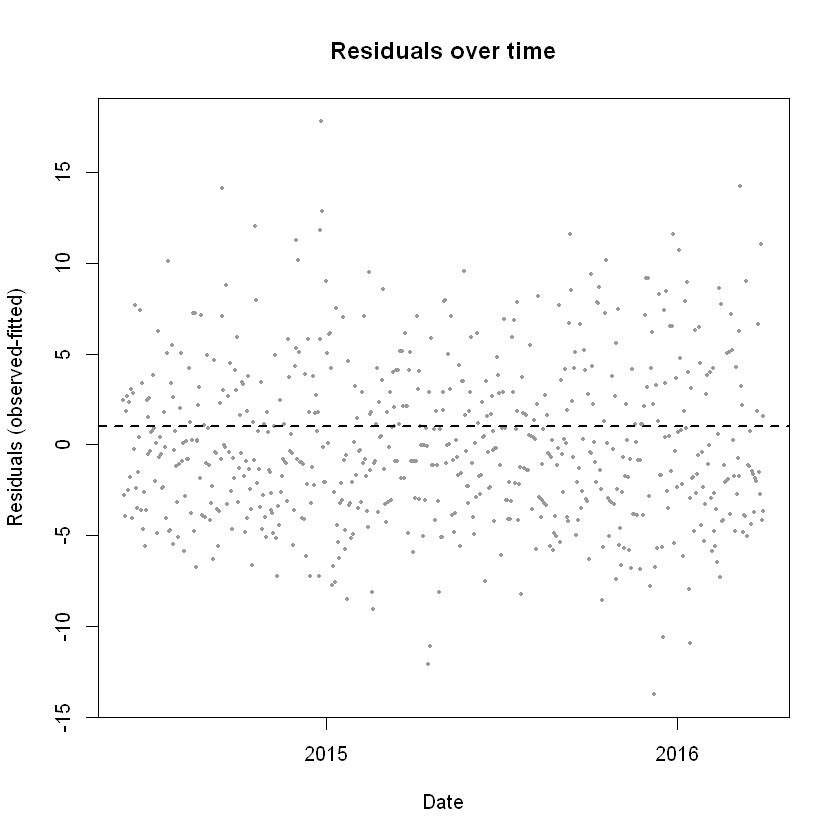

In [8]:
#####################################
# PLOT RESPONSE RESIDUALS OVER TIME
# FROM MODEL 3
#####################################

# GENERATE RESIDUALS
res3 <- residuals(model3,type="response")

############
# FIGURE 3
############

plot(data$date,res3,pch=19,cex=0.4,col=grey(0.6),
  main="Residuals over time",ylab="Residuals (observed-fitted)",xlab="Date")
abline(h=1,lty=2,lwd=2)

#,ylim=c(-50,150)

In [9]:
################################################################################
# ESTIMATING OZONE-MORTALITY ASSOCIATION
# (CONTROLLING FOR CONFOUNDERS)
############################################


#date year month target phe_resp_virus_tests_total temperature pm10_ugm3 relative_humidity_percrh date_count

# COMPARE THE RR (AND CI)
# (COMPUTED WITH THE FUNCTION ci.lin IN PACKAGE Epi, TO BE INSTALLED AND LOADED)
install.packages("Epi", repos='http://cran.us.r-project.org')
library(Epi)

package 'Epi' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\bjk1y13\AppData\Local\Temp\RtmpCk5xk9\downloaded_packages


Warning message:
"package 'Epi' was built under R version 3.5.3"

In [10]:
# UNADJUSTED MODEL
model4 <- glm(target ~ pollutant,data,family=quasipoisson)
summary(model4)
(eff4 <- ci.lin(model4,subset="pollutant",Exp=T))

# CONTROLLING FOR SEASONALITY (WITH FOURRIER AS IN MODEL 2)
# model5 <- update(model4,.~.+fourier)
model5 <- update(model4,.~.+fourier)
summary(model5)
(eff5 <- ci.lin(model5,subset="pollutant",Exp=T))


Call:
glm(formula = target ~ pollutant, family = quasipoisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.1477  -0.9781  -0.1524   0.7219   4.9830  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.555893   0.033995  75.185   <2e-16 ***
pollutant   0.002552   0.001707   1.495    0.135    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for quasipoisson family taken to be 2.041223)

    Null deviance: 1362.5  on 666  degrees of freedom
Residual deviance: 1358.0  on 665  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 4


,Estimate,StdErr,z,P,exp(Est.),2.5%,97.5%
pollutant,0.002551929,0.001707408,1.494621,0.1350133,1.002555,0.9992058,1.005916



Call:
glm(formula = target ~ pollutant + fourier, family = quasipoisson, 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.0204  -0.8808  -0.1205   0.6732   3.3662  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.614460   0.029736  87.924  < 2e-16 ***
pollutant   -0.002549   0.001531  -1.665  0.09647 .  
fourier1    -0.115399   0.018874  -6.114 1.66e-09 ***
fourier2    -0.030992   0.019103  -1.622  0.10520    
fourier3     0.082473   0.018504   4.457 9.77e-06 ***
fourier4    -0.237835   0.019836 -11.990  < 2e-16 ***
fourier5     0.056754   0.018615   3.049  0.00239 ** 
fourier6     0.009787   0.018425   0.531  0.59547    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for quasipoisson family taken to be 1.498216)

    Null deviance: 1362.5  on 666  degrees of freedom
Residual deviance: 1003.8  on 659  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 4


,Estimate,StdErr,z,P,exp(Est.),2.5%,97.5%
pollutant,-0.002548925,0.001531256,-1.664598,0.0959929,0.9974543,0.9944652,1.000452


In [11]:
# UNADJUSTED MODEL
model4 <- glm(target ~ pollutant,data,family=quasipoisson)
summary(model4)
(eff4 <- ci.lin(model4,subset="pollutant",Exp=T))

# CONTROLLING FOR SEASONALITY (WITH SPLINE AS IN MODEL 3)
# model5 <- update(model4,.~.+fourier)
model5 <- update(model4,.~.+spl)
summary(model5)
(eff5 <- ci.lin(model5,subset="pollutant",Exp=T))


Call:
glm(formula = target ~ pollutant, family = quasipoisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.1477  -0.9781  -0.1524   0.7219   4.9830  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.555893   0.033995  75.185   <2e-16 ***
pollutant   0.002552   0.001707   1.495    0.135    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for quasipoisson family taken to be 2.041223)

    Null deviance: 1362.5  on 666  degrees of freedom
Residual deviance: 1358.0  on 665  degrees of freedom
AIC: NA

Number of Fisher Scoring iterations: 4


,Estimate,StdErr,z,P,exp(Est.),2.5%,97.5%
pollutant,0.002551929,0.001707408,1.494621,0.1350133,1.002555,0.9992058,1.005916



Call:
glm(formula = target ~ pollutant + spl, family = quasipoisson, 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.9018  -0.9126  -0.1776   0.7690   3.8291  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.240094   0.158442  14.138  < 2e-16 ***
pollutant    0.001097   0.001568   0.700 0.484346    
spl1         0.407718   0.286838   1.421 0.155673    
spl2        -0.260896   0.185640  -1.405 0.160383    
spl3         0.048468   0.213898   0.227 0.820812    
spl4         0.580331   0.175877   3.300 0.001021 ** 
spl5         0.634088   0.187246   3.386 0.000751 ***
spl6         0.097526   0.184396   0.529 0.597061    
spl7         0.334721   0.189433   1.767 0.077703 .  
spl8        -0.019249   0.189661  -0.101 0.919190    
spl9         0.141482   0.188294   0.751 0.452689    
spl10        0.640238   0.182607   3.506 0.000486 ***
spl11        0.625090   0.184980   3.379 0.000770 ***
spl12        0.550156   0.2

,Estimate,StdErr,z,P,exp(Est.),2.5%,97.5%
pollutant,0.001097258,0.001568117,0.6997294,0.4840963,1.001098,0.9980258,1.004179


In [12]:
# CONTROLLING FOR TEMPERATURE
# (TEMPERATURE MODELLED WITH CATEGORICAL VARIABLES FOR DECILES)
# (MORE SOPHISTICATED APPROACHES ARE AVAILABLE - SEE ARMSTRONG EPIDEMIOLOGY 2006)
cutoffs <- quantile(data$temperature,probs=0:10/10)
tempdecile <- cut(data$temperature,breaks=cutoffs,include.lowest=TRUE)
model6 <- update(model5,.~.+tempdecile)
summary(model6)
(eff6 <- ci.lin(model6,subset="pollutant",Exp=T))

# BUILD A SUMMARY TABLE WITH EFFECT AS PERCENT INCREASE
tabeff <- rbind(eff4,eff5,eff6)[,5:7]
tabeff <- (tabeff-1)*100
dimnames(tabeff) <- list(c("Unadjusted","Plus season/trend","Plus temperature"),
  c("RR","ci.low","ci.hi"))
round(tabeff,2)


Call:
glm(formula = target ~ pollutant + spl + tempdecile, family = quasipoisson, 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.8153  -0.8641  -0.1718   0.7107   3.7938  

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            2.170107   0.170913  12.697  < 2e-16 ***
pollutant              0.001558   0.001590   0.980 0.327427    
spl1                   0.530095   0.298635   1.775 0.076362 .  
spl2                  -0.206979   0.188097  -1.100 0.271575    
spl3                   0.065108   0.216198   0.301 0.763398    
spl4                   0.629754   0.179190   3.514 0.000472 ***
spl5                   0.722044   0.197951   3.648 0.000286 ***
spl6                   0.172673   0.190273   0.907 0.364484    
spl7                   0.372154   0.195265   1.906 0.057110 .  
spl8                   0.030901   0.192571   0.160 0.872566    
spl9                   0.184599   0.192801   0.957 0.338696    
sp

,Estimate,StdErr,z,P,exp(Est.),2.5%,97.5%
pollutant,0.001558238,0.001589946,0.9800567,0.3270581,1.001559,0.9984432,1.004685


,RR,ci.low,ci.hi
Unadjusted,0.26,-0.08,0.59
Plus season/trend,0.11,-0.20,0.42
Plus temperature,0.16,-0.16,0.47


,RR,ci.low,ci.hi
Lag 0,1.0015595,0.9984432,1.004685
Lag 1,1.0028867,0.9997871,1.005996
Lag 2,1.0027026,0.9996242,1.005790
Lag 3,1.0020264,0.9989026,1.005160
Lag 4,1.0012979,0.9981540,1.004452
Lag 5,1.0011556,0.9979786,1.004343
Lag 6,1.0004088,0.9972153,1.003612
Lag 7,0.9999822,0.9967666,1.003208


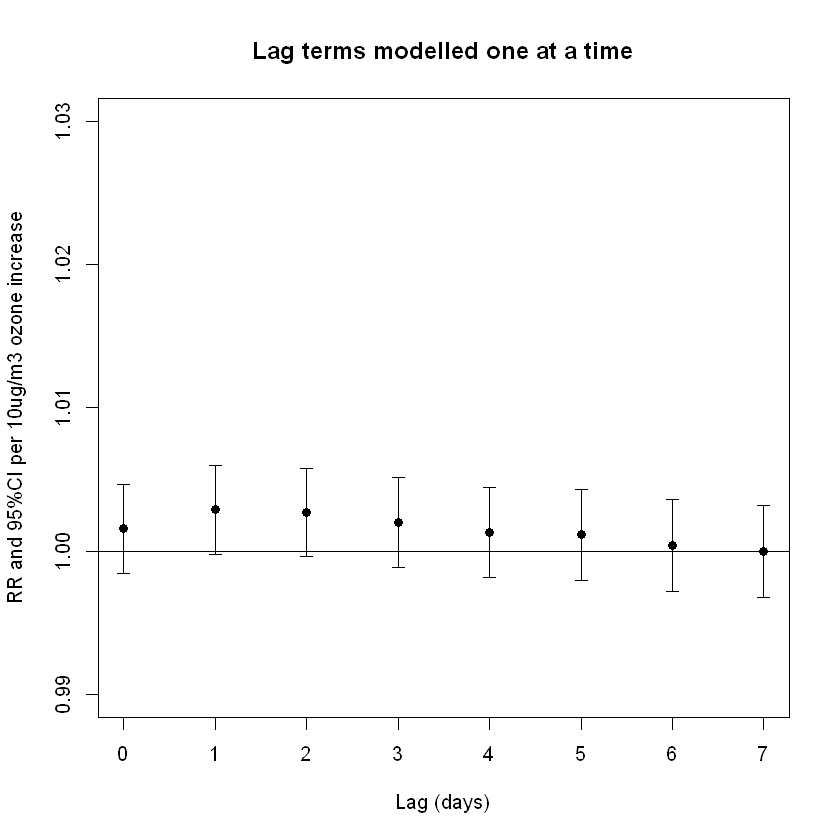

In [13]:
################################################################################
# EXPLORING THE LAGGED (DELAYED) EFFECTS
############################################

#####################
# SINGLE-LAG MODELS
#####################

# PREPARE THE TABLE WITH ESTIMATES
tablag <- matrix(NA,7+1,3,dimnames=list(paste("Lag",0:7),
  c("RR","ci.low","ci.hi")))

# RUN THE LOOP
for(i in 0:7) {
  # LAG OZONE AND TEMPERATURE VARIABLES
  pollutantlag <- Lag(data$pollutant,i)
  tempdecilelag <- cut(Lag(data$temperature,i),breaks=cutoffs,
    include.lowest=TRUE)
  # DEFINE THE TRANSFORMATION FOR TEMPERATURE
  # LAG SAME AS ABOVE, BUT WITH STRATA TERMS INSTEAD THAN LINEAR
  mod <- glm(target ~ pollutantlag + tempdecilelag + spl,data,
    family=quasipoisson)
  tablag[i+1,] <- ci.lin(mod,subset="pollutantlag",Exp=T)[5:7]
}
tablag

#############
# FIGURE 4A
#############

plot(0:7,0:7,type="n",ylim=c(0.99,1.03),main="Lag terms modelled one at a time",
  xlab="Lag (days)",ylab="RR and 95%CI per 10ug/m3 ozone increase")
abline(h=1)
arrows(0:7,tablag[,2],0:7,tablag[,3],length=0.05,angle=90,code=3)
points(0:7,tablag[,1],pch=19)

In [14]:
#####################
# UNCONSTRAINED DLM
#####################

# FACILITATED BY THE FUNCTIONS IN PACKAGE dlnm, TO BE DOWNLOADED AND LOADED
install.packages("dlnm", repos='http://cran.us.r-project.org')

library(dlnm)

package 'dlnm' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\bjk1y13\AppData\Local\Temp\RtmpCk5xk9\downloaded_packages


Warning message:
"package 'dlnm' was built under R version 3.5.3"This is dlnm 2.3.9. For details: help(dlnm) and vignette('dlnmOverview').


Warning message in checkcrossbasis(argvar, arglag, list(...)):
"argument 'type' replaced by 'fun'. See ?onebasis"Warning message in checkcrossbasis(argvar, arglag, list(...)):
"argument 'type' replaced by 'fun'. See ?onebasis"Warning message in checkonebasis(fun, args, cen):
"centering through 'cen' now applied at the prediction stage. See ?crosspred"

CROSSBASIS FUNCTIONS
observations: 667 
range: 5 to 78 
lag period: 0 7 
total df:  8 

BASIS FOR VAR:
fun: lin 
intercept: FALSE 

BASIS FOR LAG:
fun: integer 
values: 0 1 2 3 4 5 6 ... 
intercept: TRUE 



Warning message in checkcrossbasis(argvar, arglag, list(...)):
"argument 'type' replaced by 'fun'. See ?onebasis"Warning message in checkcrossbasis(argvar, arglag, list(...)):
"argument 'type' replaced by 'fun'. See ?onebasis"Warning message in checkonebasis(fun, args, cen):
"argument 'knots' replaced by 'breaks' in function strata. See ?strata"

CROSSBASIS FUNCTIONS
observations: 667 
range: -2.4 to 19.8 
lag period: 0 7 
total df:  72 

BASIS FOR VAR:
fun: strata 
df: 9 
breaks: 2.2 4.7 6.1 7.74 9.3 10.8 12.02 ... 
ref: 1 
intercept: FALSE 

BASIS FOR LAG:
fun: integer 
values: 0 1 2 3 4 5 6 ... 
intercept: TRUE 



,RR,ci.low,ci.hi
lag0,0.9730732,0.9352749,1.012399
lag1,1.0051788,0.9610880,1.051292
lag2,1.0050051,0.9601365,1.051970
lag3,0.9962423,0.9513147,1.043292
lag4,0.9881754,0.9436930,1.034755
lag5,1.0073208,0.9621913,1.054567
lag6,0.9874643,0.9428618,1.034177
lag7,0.9860639,0.9468066,1.026949


10 
0.9491838

10 
0.8969384

10 
1.004472

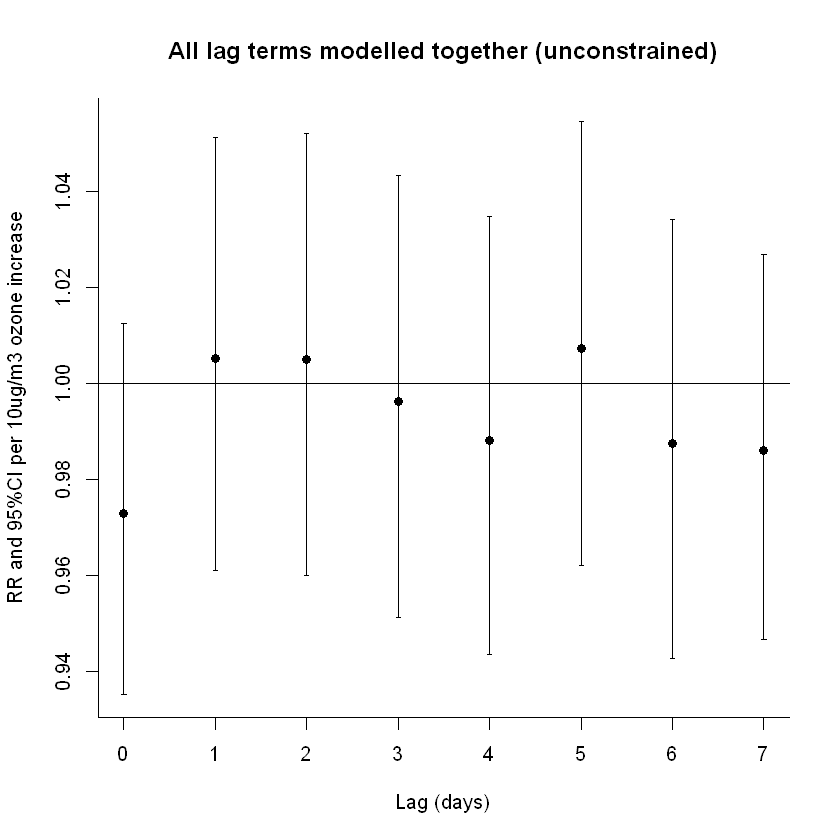

In [15]:
# IN PARTICULAR, THE FUNCTION crossbasis PRODUCES THE TRANSFORMATION FOR 
#   SPECIFIC LAG STRUCTURES AND OPTIONALLY FOR NON-LINEARITY
# THE FUNCTION crosspred INSTEAD PREDICTS ESTIMATED EFFECTS

# PRODUCE THE CROSS-BASIS FOR OZONE (SCALING NOT NEEDED)
# A SIMPLE UNSTRANSFORMED LINEAR TERM AND THE UNCONSTRAINED LAG STRUCTURE
cbo3unc <- crossbasis(data$pollutant,lag=c(0,7),argvar=list(type="lin",cen=FALSE),
  arglag=list(type="integer"))
summary(cbo3unc)

# PRODUCE THE CROSS-BASIS FOR TEMPERATURE
# AS ABOVE, BUT WITH STRATA DEFINED BY INTERNAL CUT-OFFS
cbtempunc <- crossbasis(data$temperature,lag=c(0,7),
  argvar=list(type="strata",knots=cutoffs[2:10]),
  arglag=list(type="integer"))
summary(cbtempunc)

# RUN THE MODEL AND OBTAIN PREDICTIONS FOR OZONE LEVEL 10ug/m3
model7 <- glm(target ~ cbo3unc + cbtempunc + fourier,data,family=quasipoisson)
pred7 <- crosspred(cbo3unc,model7,at=10)

# ESTIMATED EFFECTS AT EACH LAG
tablag2 <- with(pred7,t(rbind(matRRfit,matRRlow,matRRhigh)))
colnames(tablag2) <- c("RR","ci.low","ci.hi")
tablag2

# OVERALL CUMULATIVE (NET) EFFECT
pred7$allRRfit ; pred7$allRRlow ; pred7$allRRhigh

#############
# FIGURE 4B
#############
#ylim=c(0.99,1.03)
plot(pred7,var=10,type="p",ci="bars",col=1,pch=19,
  main="All lag terms modelled together (unconstrained)",xlab="Lag (days)",
  ylab="RR and 95%CI per 10ug/m3 ozone increase")

Warning message in checkcrossbasis(argvar, arglag, list(...)):
"argument 'type' replaced by 'fun'. See ?onebasis"Warning message in checkcrossbasis(argvar, arglag, list(...)):
"argument 'type' replaced by 'fun'. See ?onebasis"Warning message in checkonebasis(fun, args, cen):
"centering through 'cen' now applied at the prediction stage. See ?crosspred"Warning message in checkonebasis(fun, args, cen):
"argument 'knots' replaced by 'breaks' in function strata. See ?strata"

CROSSBASIS FUNCTIONS
observations: 667 
range: 5 to 78 
lag period: 0 7 
total df:  3 

BASIS FOR VAR:
fun: lin 
intercept: FALSE 

BASIS FOR LAG:
fun: strata 
df: 3 
breaks: 1 3 
ref: 1 
intercept: TRUE 



,RR,ci.low,ci.hi
lag0,0.9956543,0.9590120,1.033697
lag1,1.0172694,0.9952618,1.039764
lag2,1.0172694,0.9952618,1.039764
lag3,1.0034802,0.9919162,1.015179
lag4,1.0034802,0.9919162,1.015179
lag5,1.0034802,0.9919162,1.015179
lag6,1.0034802,0.9919162,1.015179
lag7,1.0034802,0.9919162,1.015179


10 
1.048394

10 
0.9835281

10 
1.117538

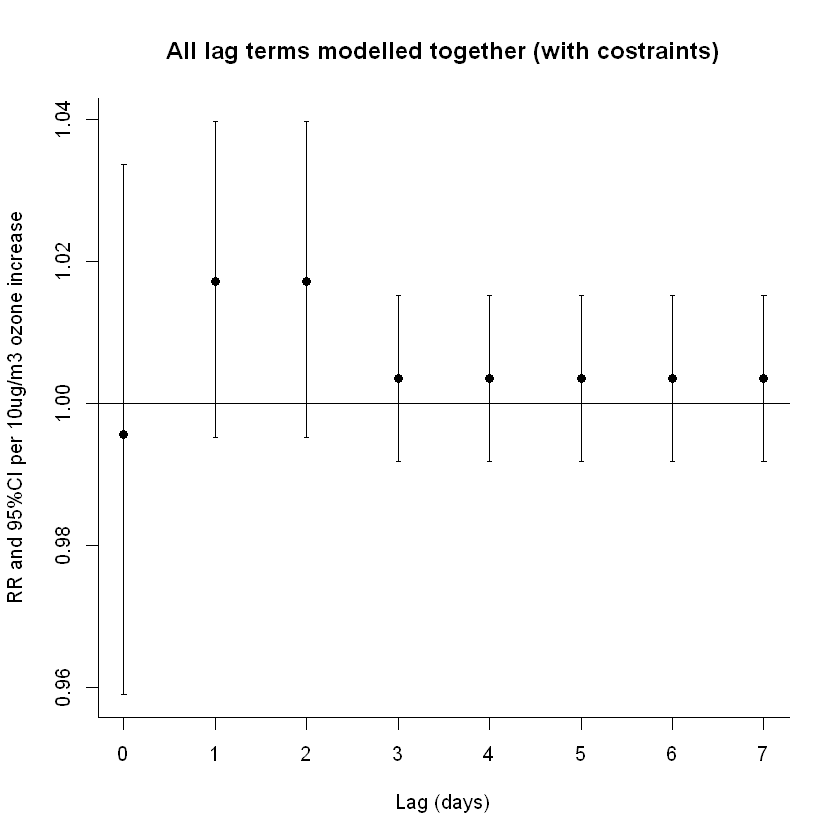

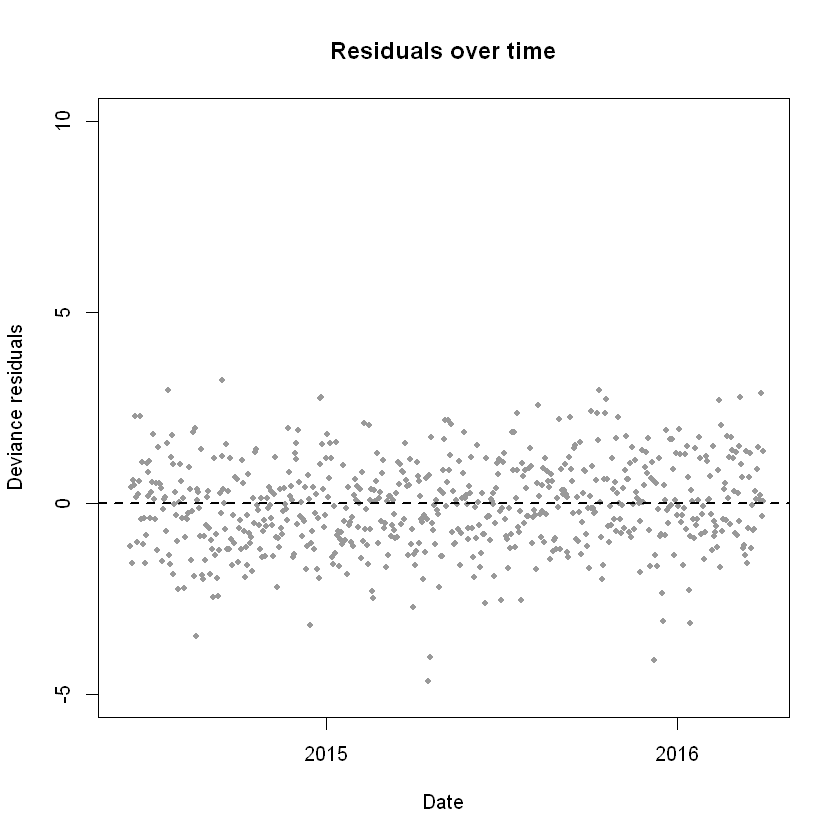

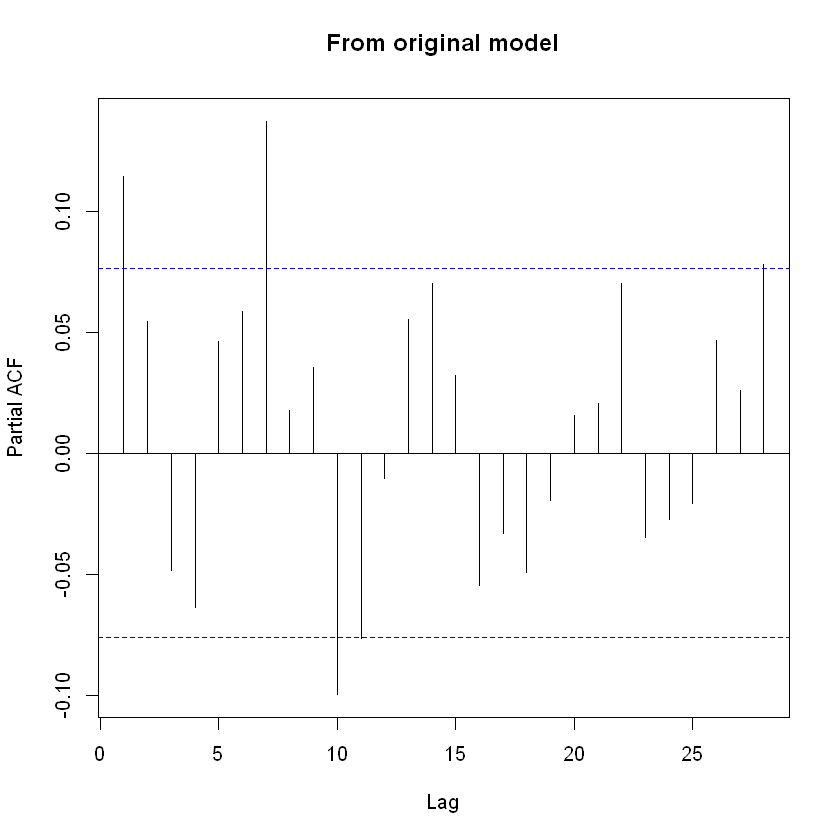

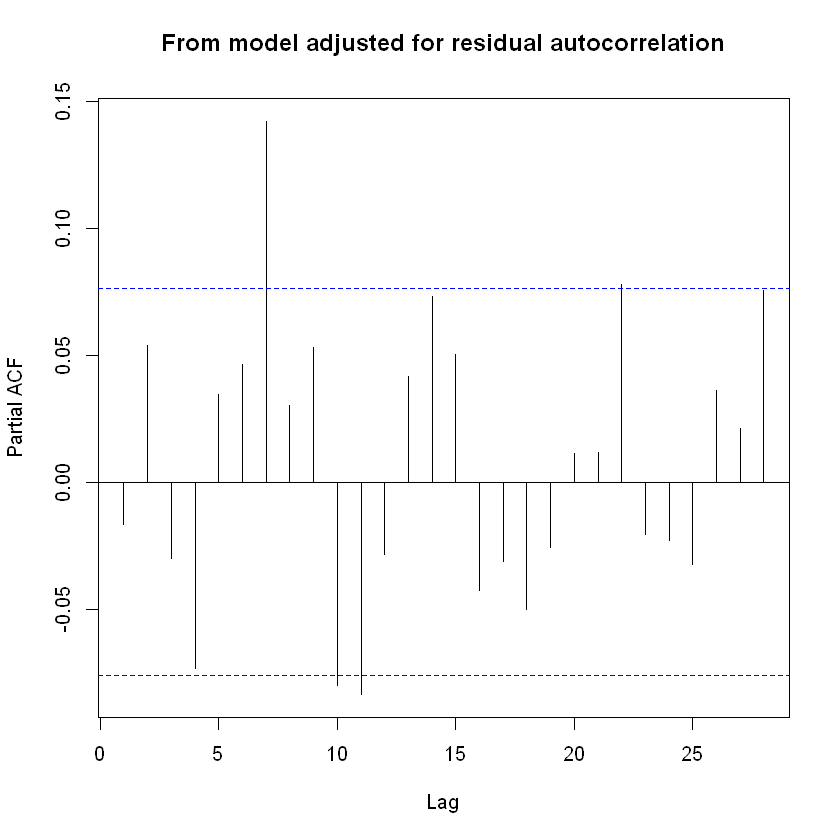

In [16]:
####################################
# CONSTRAINED (LAG-STRATIFIED) DLM
####################################

# PRODUCE A DIFFERENT CROSS-BASIS FOR OZONE
# USE STRATA FOR LAG STRUCTURE, WITH CUT-OFFS DEFINING RIGHT-OPEN INTERVALS 
cbo3constr <- crossbasis(data$pollutant,lag=c(0,7),argvar=list(type="lin",cen=FALSE),
  arglag=list(type="strata",knots=c(1,3)))
summary(cbo3constr)

# RUN THE MODEL AND OBTAIN PREDICTIONS FOR OZONE LEVEL 10ug/m3
model8 <- glm(target ~ cbo3constr + cbtempunc + spl,data,family=quasipoisson)
pred8 <- crosspred(cbo3constr,model8,at=10)

# ESTIMATED EFFECTS AT EACH LAG
tablag3 <- with(pred8,t(rbind(matRRfit,matRRlow,matRRhigh)))
colnames(tablag3) <- c("RR","ci.low","ci.hi")
tablag3

# OVERALL CUMULATIVE (NET) EFFECT
pred8$allRRfit ; pred8$allRRlow ; pred8$allRRhigh

#############
# FIGURE 4C
#############

plot(pred8,var=10,type="p",ci="bars",col=1,pch=19,
  main="All lag terms modelled together (with costraints)",xlab="Lag (days)",
  ylab="RR and 95%CI per 10ug/m3 ozone increase")

################################################################################
# MODEL CHECKING
##################

# GENERATE DEVIANCE RESIDUALS FROM UNCONSTRAINED DISTRIBUTED LAG MODEL
res7 <- residuals(model7,type="deviance")

#############
# FIGURE A1
#############

plot(data$date,res7,ylim=c(-5,10),pch=19,cex=0.7,col=grey(0.6),
  main="Residuals over time",ylab="Deviance residuals",xlab="Date")
abline(h=0,lty=2,lwd=2)

#############################
# FIGURE A2a
#############################

pacf(res7,na.action=na.omit,main="From original model")

# INCLUDE THE 1-DAY LAGGED RESIDUAL IN THE MODEL
model9 <- update(model7,.~.+Lag(res7,1))

#############################
# FIGURE A2b
#############################

pacf(residuals(model9,type="deviance"),na.action=na.omit,
  main="From model adjusted for residual autocorrelation")

#